In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class SORGP:
  def __init__(self, inducing_points, dim, device="cuda" ):
    self.M = len(inducing_points)
    self.D = dim
    self.device = device
    self.inducing_points = torch.tensor( inducing_points, device=self.device )

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.D).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.D).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt, device=self.device)
    self.yt = torch.tensor(yt, device=self.device)
    N = len(xt)


    self.sig2 = 1.0

    # カーネル行列を定義
    self.Kmm = self.cov( self.inducing_points, self.inducing_points )
    self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M, device=self.device) )
    self.Knm = self.cov( self.xt, self.inducing_points )
    self.Kmn = torch.t( self.Knm )
    self.Knn = self.cov( self.xt, self.xt )
    self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

    self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.Kmn, self.Knm) )


  def plot(self, x):
      mus, sigmas = self.predict( x.reshape(-1,1) )
      plt.plot( x, mus )
      
      y_max = mus + np.sqrt(sigmas.flatten())
      y_min = mus - np.sqrt(sigmas.flatten())

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.inducing_points.detach().cpu().numpy():
        plt.plot( p, [0.0], "kx" )
      plt.plot(self.xt.cpu(), self.yt.cpu())
      plt.show()

  def predict( self, x ):
    x = torch.tensor(x, device=self.device)
    mus = []
    sigmas = []
    K = len(x)

    Kxm = self.cov( x.reshape(-1,1), self.inducing_points )
    Kmx = torch.t( Kxm )

    sig = torch.mm(torch.mm( Kxm, self.S ), Kmx )
    mu = 1/self.sig2 * torch.mm( torch.mm( torch.mm(Kxm, self.S ), self.Kmn), self.yt.reshape(-1,1) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()


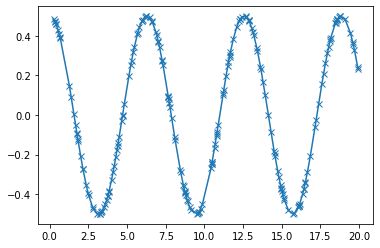

In [2]:
xt = np.sort(np.random.rand(200)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

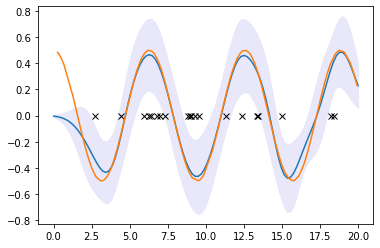

CPU times: user 174 ms, sys: 3.27 ms, total: 177 ms
Wall time: 179 ms


In [17]:
%%time
gp = SORGP( np.random.rand(20,1)*20 , 1, "cpu")
gp.learn( xt.reshape((-1,1)), yt )
gp.plot(np.linspace( 0,20,100 ))

In [18]:
%%time
gp.predict(np.linspace( 0,20,100 ).reshape(-1,1))

CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 1.11 ms


(array([-0.00458962, -0.0078304 , -0.01284759, -0.02028467, -0.0308453 ,
        -0.04522326, -0.06401623, -0.08764207, -0.1162764 , -0.14981946,
        -0.18787742, -0.22971854, -0.27415586, -0.31933275, -0.3624535 ,
        -0.39958895, -0.42575134, -0.4354145 , -0.42352079, -0.38678682,
        -0.32489531, -0.24107275, -0.14170647, -0.03502146,  0.07073321,
         0.16889625,  0.25520402,  0.32760499,  0.38537929,  0.42813705,
         0.45521817,  0.46566439,  0.45858716,  0.43361329,  0.39116293,
         0.33252838,  0.25982681,  0.17590098,  0.08421184, -0.01134908,
        -0.10664542, -0.19752624, -0.28004088, -0.35062112, -0.40629688,
        -0.44481941, -0.4647872 , -0.46569594, -0.44783615, -0.41226524,
        -0.36070707, -0.2954176 , -0.21895401, -0.13393746, -0.04298036,
         0.05113281,  0.1450584 ,  0.2345688 ,  0.31464541,  0.38016999,
         0.42707028,  0.45342756,  0.45995676,  0.44949858,  0.42563223,
         0.39098876,  0.34605939,  0.28912172,  0.2